# AKI - early/delayed renal treatment

*import libraries*

In [1]:
# Import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import (RidgeCV, 
                                  LassoCV, 
                                  ElasticNetCV, 
                                  LogisticRegressionCV,
                                  LinearRegression,
                                  LogisticRegression)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import (confusion_matrix, 
                              
                             roc_auc_score, 
                              
                             accuracy_score,
                            )
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
aki_data = pd.read_csv('cleaned_data.csv')

In [3]:
pd.set_option('display.max_columns', 100)
aki_data.head()

,weight,aki_stage,delay_rrt,gender,admission_age,ethnicity,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,inr_max,pt_max,ptt_max,heart_rate_mean,sbp_mean,dbp_mean,mbp_mean,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,gcs_min
0,104.50,1,1,1,66.262081,unknown,31.4,31.9,11.3,11.3,246.0,247.0,11.2,11.2,20.0,23.0,23.0,24.0,109.0,114.0,8.7,9.5,106.0,114.0,3.0,3.1,172.0,317.0,146.0,154.0,3.9,4.1,1.3,14.6,47.5,89.625000,132.500000,68.5000,83.090909,21.673077,37.405000,96.909091,257.500000,10
1,100.00,1,1,1,70.489938,NaN,34.0,34.2,11.3,11.4,185.0,186.0,12.1,13.5,14.0,16.0,20.0,21.0,36.0,41.0,7.5,7.7,103.0,104.0,1.1,1.1,106.0,140.0,134.0,135.0,4.4,4.8,1.3,13.9,25.0,84.208333,107.500000,56.4600,74.019231,17.134615,36.978000,96.680000,123.666667,3
2,98.95,3,0,1,37.700917,unknown,27.1,29.4,9.9,10.4,185.0,252.0,22.4,31.1,26.0,30.0,15.0,18.0,40.0,53.0,7.4,10.2,73.0,76.0,7.8,10.5,121.0,228.0,118.0,119.0,3.3,3.8,2.6,27.5,36.0,80.956522,101.958333,52.4375,67.541667,20.000000,36.132143,95.250000,152.625000,6
3,105.70,3,1,0,59.967156,white,25.0,30.9,8.1,10.1,70.0,107.0,7.6,14.5,11.0,13.0,19.0,23.0,15.0,16.0,7.5,7.8,106.0,110.0,1.1,1.2,47.0,127.0,140.0,141.0,3.2,4.0,2.6,28.4,51.3,87.521739,108.000000,56.4000,70.700000,24.086957,36.776667,96.478261,102.714286,13
4,69.00,1,0,1,79.060470,white,38.0,38.0,13.2,13.2,262.0,262.0,10.8,10.8,18.0,18.0,21.0,21.0,19.0,19.0,9.4,9.4,106.0,106.0,1.3,1.3,126.0,126.0,141.0,141.0,3.7,3.7,1.2,13.8,35.6,90.318182,140.800000,71.8500,88.285714,21.000000,36.620000,95.782609,124.000000,15


In [4]:
# one-hot-encode categorical data ethnicity ?
# drop ethnicity
aki_data.drop(columns=['ethnicity'],inplace=True)

In [5]:
aki_data.drop(columns=['delay_rrt']).shape

(1778, 42)

### Polynomial features 

Any of the features could be related to each other, or have an interactive effect with each other. Any synergistic effect on delay_rrt could increase the significant predictive power to the model. 


In [6]:
X = aki_data.drop(columns=['delay_rrt'])
y = aki_data['delay_rrt']

In [7]:
# Generating the polynomial features table.  
# instantiate
poly = PolynomialFeatures(include_bias=False, degree=2)

In [8]:
# fit and transform the variables in the numerical dataframe
X_poly = poly.fit_transform(X)
X_poly.shape

(1778, 945)

In [9]:
# Checking column names to all polynomial features
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))


In [10]:
# Gennerating list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)

In [11]:
# Shows top 20 features most positively correlated with delay_rrt
X_poly_corrs.sort_values(ascending=False).head(20)

chloride_min temperature_mean       0.198818
chloride_min spo2_mean              0.182815
chloride_min^2                      0.180279
chloride_min                        0.179294
bicarbonate_min chloride_min        0.158487
bicarbonate_min chloride_max        0.152728
chloride_min sodium_min             0.148421
calcium_min chloride_min            0.145373
chloride_min chloride_max           0.144399
admission_age bicarbonate_min       0.140705
admission_age chloride_min          0.137339
bicarbonate_min temperature_mean    0.132319
bicarbonate_min sodium_min          0.130960
bicarbonate_min spo2_mean           0.130260
bicarbonate_min                     0.128809
bicarbonate_min sodium_max          0.126990
bicarbonate_min heart_rate_mean     0.123727
calcium_min chloride_max            0.121496
chloride_max temperature_mean       0.121356
chloride_min sodium_max             0.119685
dtype: float64

In [12]:
# Shows bottom 20 features most positively correlated with delay_rrt
X_poly_corrs.sort_values(ascending=False).tail(20) 

aniongap_max gcs_min            -0.248238
aniongap_max temperature_mean   -0.249200
aniongap_max sodium_max         -0.249964
aniongap_max spo2_mean          -0.250221
aniongap_max calcium_max        -0.254303
aniongap_max                    -0.254689
aniongap_max^2                  -0.255885
creatinine_max resp_rate_mean   -0.256791
creatinine_max gcs_min          -0.257502
hemoglobin_max creatinine_max   -0.257905
aniongap_min creatinine_max     -0.258068
aniongap_max sbp_mean           -0.259088
hematocrit_max creatinine_max   -0.259116
calcium_max creatinine_max      -0.259650
aniongap_min potassium_max      -0.260355
aniongap_max dbp_mean           -0.262543
creatinine_max potassium_max    -0.273823
aniongap_max mbp_mean           -0.274197
aniongap_max creatinine_max     -0.290806
aniongap_max potassium_max      -0.291583
dtype: float64

In [13]:
# # Adding interaction features into train set ?
# aki_data['aniongap_max*potassium_max'] = aki_data['aniongap_max'] * aki_data['potassium_max']
# aki_data['calcium_max*creatinine_max'] = aki_data['calcium_max'] * aki_data['creatinine_max']

In [14]:
# X = aki_data.drop(columns=['delay_rrt'])
# y = aki_data[['delay_rrt']]

In [15]:
# train test split
# X_train, y_train : 50%
# X_valid, y_valid : 25%
# X_test, y_test   : 25%

### Baseline model (with SMOTE)

From the correlated features, it seemed that 'aniongap_max' has the highest (negative) correlation. So will start with this. 

In [16]:
X_sm = aki_data[['aniongap_max']]
y_sm = aki_data[['delay_rrt']]

In [17]:
# imbalanced 
y_sm.value_counts(normalize=True)

delay_rrt
1            0.814961
0            0.185039
Name: proportion, dtype: float64

In [18]:
# split data
Xsm_train, Xsm_test, ysm_train, ysm_test = train_test_split(X_sm, y_sm, test_size = 0.33, random_state=42, stratify =y)

In [19]:
# scaling
ss = StandardScaler()

Xsm_train_sc = ss.fit_transform(Xsm_train)
Xsm_test_sc = ss.transform(Xsm_test)

In [20]:
# create synthetic data for training set
smote = SMOTE()

In [21]:
# Xsmote_train, ysmote_train = smote.fit_sample(Xsm_train_sc, ysm_train)
Xsmote_train, ysmote_train = smote.fit_resample(Xsm_train_sc, ysm_train)

In [22]:
smote.fit

<bound method BaseSampler.fit of SMOTE()>

In [23]:
# balanced
ysmote_train.value_counts()

delay_rrt
0            971
1            971
Name: count, dtype: int64

In [24]:
# instantiate
lr = LogisticRegression()

# fit model
lr.fit(Xsmote_train, ysmote_train)

# score
lr.score(Xsmote_train, ysmote_train), lr.score(Xsm_test_sc, ysm_test)

(0.6029866117404737, 0.6695059625212947)

So the **baseline accuracy** is 0.620 (for train set), and 0.670 (for test set)

## Feature selection

### Logistic regression (with SMOTE)

In [25]:
# from previous notebook
# drop the above columns
aki_data.drop(columns=['gender','sbp_mean','dbp_mean'],inplace=True)

In [26]:
aki_data.drop(columns=['delay_rrt']).shape

(1778, 39)

In [27]:
# using (most) entire dataset WITHOUT polynomic features
X = aki_data.drop(columns=['delay_rrt'])
y = aki_data[['delay_rrt']]

In [28]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify =y)

In [29]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE(sampling_strategy='minority')),
        ('logreg', LogisticRegression(max_iter=1_000, solver='saga'))
    ])


In [30]:
# regardless of parameters, there is overfitting.
pipe_params = {
    'sampling__k_neighbors': [5, 10],   # 
    'logreg__penalty': ['l2', 'l1'],   # 
    'logreg__C': [1] # 
}

In [31]:
grid = GridSearchCV(pipe, pipe_params, scoring='roc_auc', n_jobs=-1)

In [32]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling',
                                        SMOTE(sampling_strategy='minority')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__penalty': ['l2', 'l1'],
                         'sampling__k_neighbors': [5, 10]},
             scoring='roc_auc')

In [33]:
grid.best_params_

{'logreg__C': 1, 'logreg__penalty': 'l2', 'sampling__k_neighbors': 10}

In [34]:
grid.score(X_train, y_train), grid.score(X_test, y_test)

(0.8287332646755923, 0.7247898353230202)

Accuracy for train set is 0.831, while test set is 0.726. 

In [35]:
# getting feature importance 
lr_coef = grid.best_estimator_.named_steps['logreg'].coef_

In [36]:
coef_tot = pd.DataFrame(list(zip(X.columns,lr_coef[0])))
coef_tot.columns = ['variable','coef']
coef_tot.sort_values(by='coef',ascending=False)

,variable,coef
15,bun_min,1.923658
10,wbc_max,1.124585
3,hematocrit_min,0.746575
19,chloride_min,0.591444
13,bicarbonate_min,0.540199
22,creatinine_max,0.495769
35,temperature_mean,0.494219
6,hemoglobin_max,0.412723
31,ptt_max,0.405451
17,calcium_min,0.293705


**top 5 features**

In [37]:
coef_tot.sort_values(by='coef',ascending=False).head()

,variable,coef
15,bun_min,1.923658
10,wbc_max,1.124585
3,hematocrit_min,0.746575
19,chloride_min,0.591444
13,bicarbonate_min,0.540199


There is 18x higher likelihood to receive delayed rrt with one unit increase in bun_min, compared to features such as 'platelets_max', 'inr_max', 'glucose_min', 'chloride_max', 'aniongap_min', 'heart_rate_mean', 'glucose_max', 'glucose_mean',	'mbp_mean', 'platelets_min'.

**negative features**

In [38]:
coef_tot.sort_values(by='coef').head()

,variable,coef
16,bun_max,-1.318420
21,creatinine_min,-1.239746
9,wbc_min,-0.868129
5,hemoglobin_min,-0.741718
4,hematocrit_max,-0.440026


There is 12x higher likelihood to NOT receive delayed rrt with one unit increase in bun_max, compared to features such as 'platelets_max', 'inr_max', 'glucose_min', 'chloride_max', 'aniongap_min', 'heart_rate_mean', 'glucose_max', 'glucose_mean',	'mbp_mean', 'platelets_min'.

## Feature extraction

For feature extraction, we will use PCA to identify and keep those potential important relationships, before performing the predictions/models. Due to the number of features (and high-dimensional manifold) in our dataset, PCA was utilised to perform an unsupervised dimensionality reduction on the training dataset. In such a way, PCA will provide the best linear approximations before modeling and prediction was performed ([source](https://arxiv.org/ftp/arxiv/papers/1403/1403.1949.pdf)). GridSearchCV is used to set the dimensionality of the PCA. 

In [39]:
# including polynomial features
abs(X_poly_corrs).sort_values(ascending=False).head(20)

aniongap_max potassium_max       0.291583
aniongap_max creatinine_max      0.290806
aniongap_max mbp_mean            0.274197
creatinine_max potassium_max     0.273823
aniongap_max dbp_mean            0.262543
aniongap_min potassium_max       0.260355
calcium_max creatinine_max       0.259650
hematocrit_max creatinine_max    0.259116
aniongap_max sbp_mean            0.259088
aniongap_min creatinine_max      0.258068
hemoglobin_max creatinine_max    0.257905
creatinine_max gcs_min           0.257502
creatinine_max resp_rate_mean    0.256791
aniongap_max^2                   0.255885
aniongap_max                     0.254689
aniongap_max calcium_max         0.254303
aniongap_max spo2_mean           0.250221
aniongap_max sodium_max          0.249964
aniongap_max temperature_mean    0.249200
aniongap_max gcs_min             0.248238
dtype: float64

In [40]:
# Adding top abs 20 interaction features into dataset
# aniongap_max^2 is not added, because little diff between aniongap_max (which is already in dataset)

aki_data['aniongap_max*potassium_max'] = aki_data['aniongap_max'] * aki_data['potassium_max']
aki_data['aniongap_max*creatinine_max'] = aki_data['aniongap_max'] * aki_data['creatinine_max']
aki_data['aniongap_max*mbp_mean'] = aki_data['aniongap_max'] * aki_data['mbp_mean']
aki_data['creatinine_max*potassium_max'] = aki_data['creatinine_max'] * aki_data['potassium_max']
aki_data['aniongap_min*potassium_max'] = aki_data['aniongap_min'] * aki_data['potassium_max']
aki_data['calcium_max*creatinine_max'] = aki_data['calcium_max'] * aki_data['creatinine_max']
aki_data['hematocrit_max*creatinine_max'] = aki_data['hematocrit_max'] * aki_data['creatinine_max']
aki_data['aniongap_min*creatinine_max'] = aki_data['aniongap_min'] * aki_data['creatinine_max']
aki_data['hemoglobin_max*creatinine_max'] = aki_data['hemoglobin_max'] * aki_data['creatinine_max']
aki_data['creatinine_max*gcs_min'] = aki_data['creatinine_max'] * aki_data['gcs_min']
aki_data['creatinine_max*resp_rate_mean'] = aki_data['creatinine_max'] = aki_data['resp_rate_mean']
aki_data['aniongap_max*calcium_max'] = aki_data['aniongap_max'] * aki_data['calcium_max']
aki_data['aniongap_max*spo2_mean'] = aki_data['aniongap_max'] * aki_data['spo2_mean']
aki_data['aniongap_max*sodium_max'] = aki_data['aniongap_max'] * aki_data['sodium_max']
aki_data['aniongap_max*temperature_mean'] = aki_data['aniongap_max'] * aki_data['temperature_mean']
aki_data['aniongap_max*gcs_min'] = aki_data['aniongap_max'] * aki_data['gcs_min']
# aki_data['chloride_min*temperature_mean'] = aki_data['chloride_min'] * aki_data['temperature_min']
# aki_data['bicarbonate_min*chloride_max'] = aki_data['bicarbonate_min'] * aki_data['chloride_max']

In [41]:
X = aki_data.drop(columns=['delay_rrt'])
y = aki_data[['delay_rrt']]

In [42]:
# ? + 18 = 55
X.shape 

(1778, 55)

In [43]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [44]:
# scaling
ss_pca = StandardScaler()

X_train_sc = ss_pca.fit_transform(X_train)
X_test_sc = ss_pca.transform(X_test)

In [45]:
# Instantiate PCA.
# up to n_components were tested
pca = PCA(n_components = 55)

# Fit PCA on the training data.
pca.fit(X_train_sc)

PCA(n_components=55)

In the below pipeline, PCA will perform unsupervised dimensionality reduction on the training data before upsampling it. This is so that upsampling will only be performed on the reduced dimensional manifold and not on the entire dataset. The models for the prediction will be done last. In the below pipeline, the logistic regression model was utilised. 

In [46]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA()),
        ('sampling', SMOTE(sampling_strategy='minority')),
        ('logreg', LogisticRegression(max_iter=1_000, solver='saga'))
    ])

In [47]:
pipe_params = {
    'pca__n_components': [5,10,15,20,25,30,35,40,45,50,55],  
} 

In [48]:
grid = GridSearchCV(pipe, pipe_params, scoring='roc_auc', n_jobs=-1)

In [49]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('sampling',
                                        SMOTE(sampling_strategy='minority')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 10, 15, 20, 25, 30, 35, 40,
                                               45, 50, 55]},
             scoring='roc_auc')

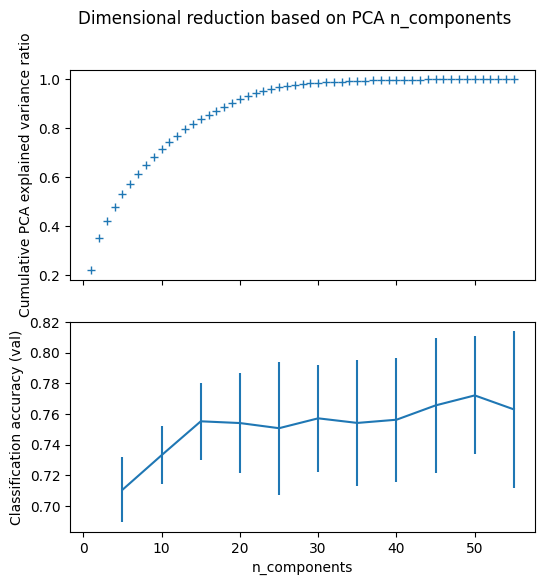

In [50]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py
# Plot search for best combination of PCA n_components and logistic regression accuracy
# pca.fit(X_train_sc)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(), '+', linewidth=10)
ax0.set_ylabel('Cumulative PCA explained variance ratio')

results = pd.DataFrame(grid.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components');
plt.suptitle('Dimensional reduction based on PCA n_components');

In [51]:
print(f'Cumulative explained variance (for n_components=20): {pca.explained_variance_ratio_.cumsum()[20]}')

Cumulative explained variance (for n_components=20): 0.9317110347308232


In [52]:
grid.best_params_

{'pca__n_components': 50}

In [53]:
grid.score(X_train, y_train), grid.score(X_test, y_test)

(0.829936335549106, 0.7233503512341177)

GridSearchCV chose n_components=45, however, there was overfitting at n_components=45. Since PCA utilises n_components, the decision is to use n_components=20, to minimise overfitting, and we would retain approximately 93% of the variability in the data.
<br>
<br> The curse is after the dataset is PCA-transformed, there is no correlation between any features. In addition, the new principal components are not interpretable. So, to dig into the feature importance, one will have to convert the PCA-transformed data back to the original features.

### Models

In [54]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=1000, solver='saga'),
        'dt': DecisionTreeClassifier(),
        'rf': RandomForestClassifier(),
        'et': ExtraTreesClassifier(),
        'svc': SVC(probability=True),
        } 

In [55]:
def run_models(model, model_params):
    pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = 30)),
            ('sampling', SMOTE(sampling_strategy = 'minority')),
            (model, models[model])
            ])
    
    grid = GridSearchCV(pipe, param_grid=model_params, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    # metrics
    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    preds = grid.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
  
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap='Blues', values_format='d')
    
    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)
    
    # Calculate the specificity
    spec = tn / (tn + fp) 
    
    # print results
    print(f'Best params: {grid.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'Recall: {round(sens, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    return grid

**Logistic Regression**

Best params: {'lr__C': 0.1, 'lr__penalty': 'l1', 'sampling__k_neighbors': 10}
Training score: 0.7999
Test score: 0.7156
Recall: 0.7218
Specificity: 0.633


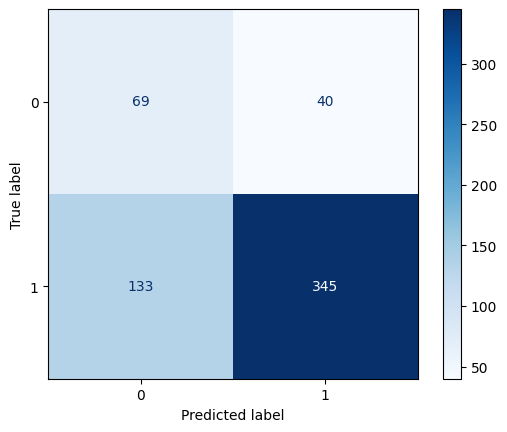

In [56]:
# logistic regression
# grid_params = {
#     'sampling__k_neighbors': [10,15,20],  
#     'lr__penalty': ['l1', 'l2',  'elasticnet'],   
#     'lr__C': [0.1, 1, 10]  
# } 

best_params = {
    'sampling__k_neighbors': [10],  
    'lr__penalty': ['l1'],   
    'lr__C': [0.1]  
}

lr = run_models('lr', best_params)

**Decision Tree Classifier**

Best params: {'dt__max_depth': 70, 'dt__min_samples_leaf': 90, 'dt__min_samples_split': 90, 'sampling__k_neighbors': 60}
Training score: 0.7666
Test score: 0.6888
Recall: 0.7008
Specificity: 0.578


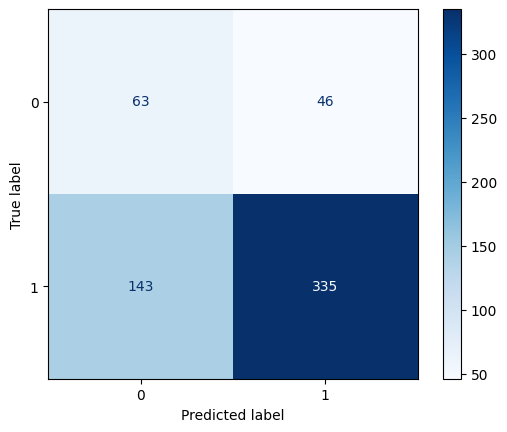

In [57]:
# decision tree classifier
# grid_params = {
#     'sampling__k_neighbors': [40, 50, 60],  
#     'dt__max_depth': [70, 80, 90],
#     'dt__min_samples_split': [70, 80, 90],
#     'dt__min_samples_leaf': [70, 80, 90],
# } 

best_params = {
    'sampling__k_neighbors': [60],  
    'dt__max_depth': [70],
    'dt__min_samples_split': [90],
    'dt__min_samples_leaf': [90],
} 

dt = run_models('dt', best_params)

**Random forest classifier**

Best params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 50, 'rf__min_samples_split': 20, 'rf__n_estimators': 20, 'sampling__k_neighbors': 30}
Training score: 0.8572
Test score: 0.6808
Recall: 0.7448
Specificity: 0.4679


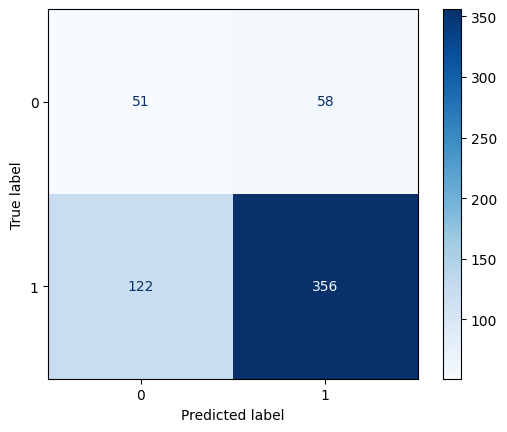

In [58]:
# random forest classifier
# grid_params = {
#     'sampling__k_neighbors': [70, 80, 90],
#     'rf__n_estimators': [70, 80, 90],
#     'rf__max_depth': [50, 80, 90],
#     'rf__min_samples_split': [70, 80, 90],
#     'rf__min_samples_leaf': [70, 80, 90],
# } 

best_params = {
    'sampling__k_neighbors': [30], 
    'rf__n_estimators': [20],
    'rf__max_depth': [10],
    'rf__min_samples_split': [20],
    'rf__min_samples_leaf': [50],
} 

rf = run_models('rf', best_params)


**Extra trees classifier**

Best params: {'et__max_depth': 4, 'et__min_samples_leaf': 10, 'et__min_samples_split': 15, 'et__n_estimators': 30, 'sampling__k_neighbors': 20}
Training score: 0.8377
Test score: 0.6586
Recall: 0.7029
Specificity: 0.5321


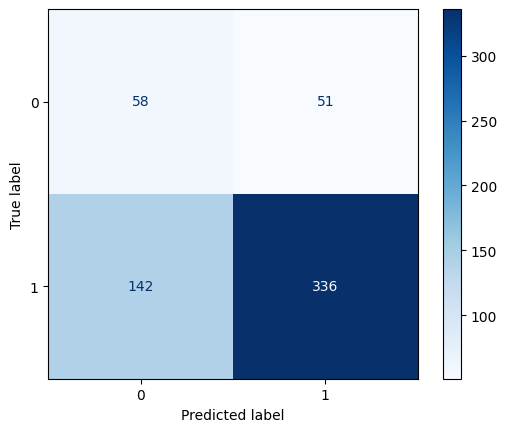

In [59]:
# extra trees classifier
# grid_params = {
#     'sampling__k_neighbors': [15, 20, 25],
#     'et__n_estimators': [30, 35],
#     'et__max_depth': [4, 5, 6],
#     'et__min_samples_split': [10, 15],
#     'et__min_samples_leaf': [10, 15],
# } 

best_params = {
    'sampling__k_neighbors': [20],
    'et__n_estimators': [30],  
    'et__max_depth': [4],  
    'et__min_samples_split': [15],
    'et__min_samples_leaf': [10],
}

et = run_models('et', best_params)

**Feature importance**

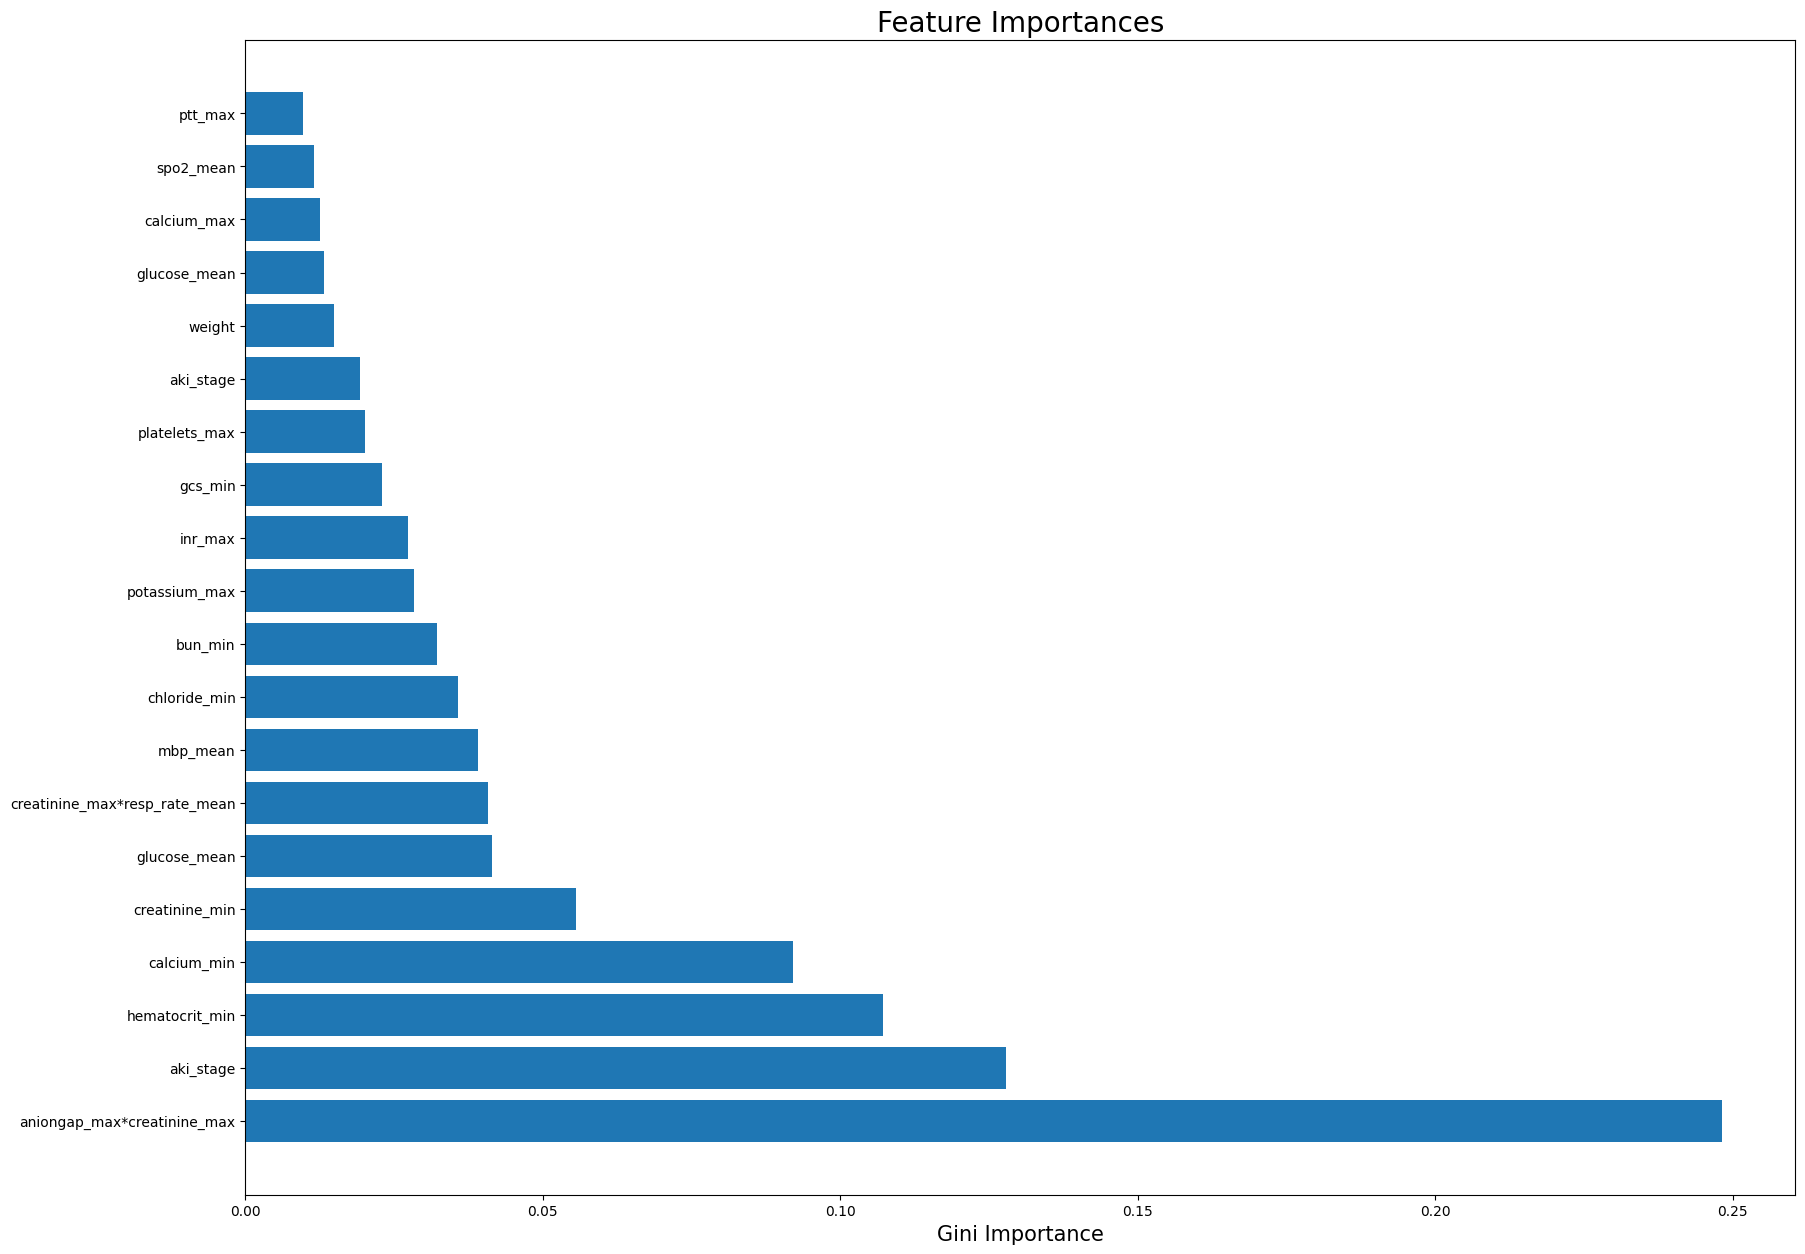

In [60]:
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
# PCA-transform data back to orignal features
num_plot = 20

pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = num_plot)),
            ('sampling', SMOTE(sampling_strategy='minority', k_neighbors=20)),
            ('rf', ExtraTreesClassifier(n_estimators=30, max_depth=6, min_samples_split = 10, min_samples_leaf = 15)),
            ])

pipe.fit(X_train, y_train)

model = pipe.steps[1][1]
n_pcs = model.components_.shape[0]

# get index for more important feature from each n_component
feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]

# combine for plotting later
zipped_feats = zip(most_important_names, pipe.steps[3][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)

# n_components = 20
top_features = features[:num_plot]
top_importances = importances[:num_plot]
plt.figure(figsize=(20,15))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.title('Feature Importances',fontsize=20)
plt.xlabel('Gini Importance',fontsize=15)
plt.show() 

**Support Vector Classification**

Best params: {'sampling__k_neighbors': 30, 'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Training score: 0.8086
Test score: 0.7294
Recall: 0.7259
Specificity: 0.6239


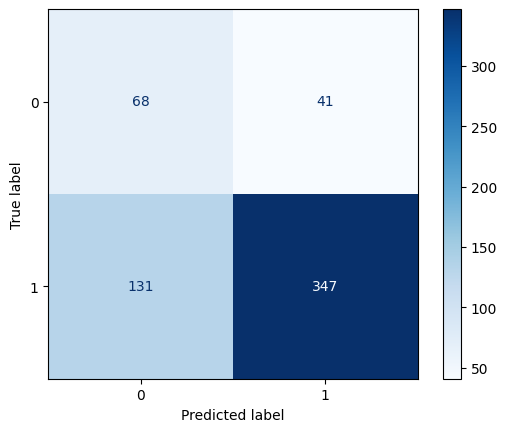

In [61]:
# Support Vector Classification
# grid_params = {
#     'sampling__k_neighbors': [25, 30],     
#     'svc__kernel': ['linear', 'sigmoid'],   
#     'svc__gamma' : ['scale', 'auto'], 
#     'svc__C': [1 ,5 ,10] 
# } 

best_params = {
    'sampling__k_neighbors': [30],     
    'svc__kernel': ['linear'],    
    'svc__gamma' : ['scale'],
    'svc__C': [10] 
} 

svc = run_models('svc', best_params)

**Feature importance**

In [62]:
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
# PCA-transform data back to orignal features
num_plot = 30

pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = num_plot)),
            ('sampling', SMOTE(sampling_strategy='minority',k_neighbors =30)),
            ('svc', SVC(C=10, gamma='auto', kernel='linear',probability=True)),
            ])

pipe.fit(X_train, y_train)

model = pipe.steps[1][1]
n_pcs = model.components_.shape[0]

# get index for more important feature from each n_component
feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]

# combine for plotting later
zipped_feats = zip(most_important_names, pipe.steps[3][1].coef_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)

# n_components = 30
top_features = features[:num_plot]
top_importances = importances[:num_plot]
print(top_features)
print(top_importances)
# plt.figure(figsize=(10,7))
# plt.barh(range(len(top_importances)), top_importances, align='center')
# plt.yticks(range(len(top_importances)), top_features)
# plt.title('Feature Importances')
# plt.xlabel('Coefficients')
# plt.show() 

('aniongap_max*creatinine_max',)
(array([-0.27058226, -0.07378305, -0.17414564,  0.06759245,  0.08020267,
       -0.03806051, -0.22646   , -0.24126564,  0.24415327, -0.12472134,
        0.0698653 , -0.04748165, -0.07952699, -0.12277845, -0.65118467,
       -0.22394312,  0.03745468, -0.01252694,  0.06787117,  0.04123364,
        0.28838664,  0.04494021, -0.02310528,  0.21470023, -0.15559294,
       -0.10142261,  0.10172225,  0.3615281 , -0.0446851 , -0.15799869]),)


## Plot ROC-AUC 

In [63]:
def plot_all_auc(models):
    fig, ax = plt.subplots(figsize=(10, 10))
    axes = {}
    for i, m in enumerate(models.keys()):
        # Use RocCurveDisplay instead of plot_roc_curve
        RocCurveDisplay.from_estimator(m, X_test, y_test, ax=ax, name=models[m])
        
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.title('ROC-AUC curve', fontsize=20)
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.legend()

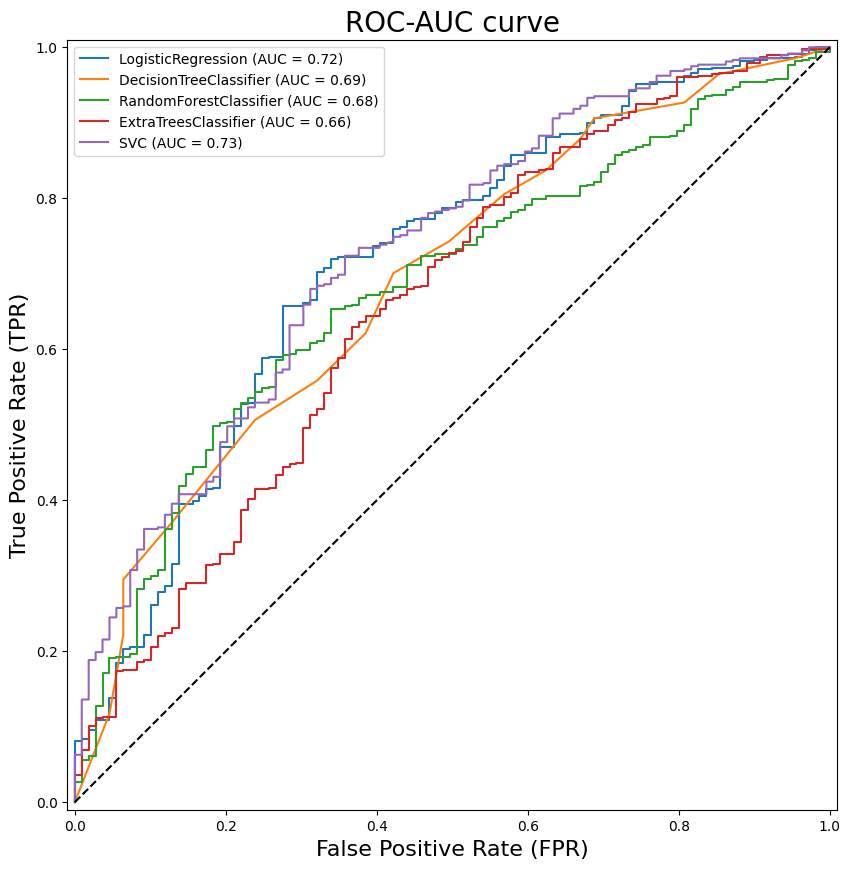

In [64]:
models_built = {
    lr : 'LogisticRegression', 
    dt : 'DecisionTreeClassifier',
    rf : 'RandomForestClassifier',
    et : 'ExtraTreesClassifier',
    svc : 'SVC',
} 

plot_all_auc(models_built)